####  **Import Required Libraries**

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error, r2_score

import joblib

####  **Load Prepared Data**

In [312]:
file_path = "../resources/data/output/customer_churn_prepared.csv"   
df = pd.read_csv(file_path)

#### **Feature Engineering**

In [313]:
# Create new binary feature: 1 = active, 0 = non-active
df["status_active"] = df["status"].apply(lambda x: 1 if x == 1 else 0)

In [314]:
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn,status_active
0,8,0,38,0,4370,5,17,3,1,1,197.640,0,1
1,0,0,39,0,318,7,4,2,1,2,46.035,0,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0,1
3,10,0,38,0,4198,1,35,1,1,1,240.020,0,1
4,3,0,38,0,2393,2,33,1,1,1,145.805,0,1


In [315]:
X = df.drop(columns=["subscription_length", "customer_value", "churn", "status"])
y = df["customer_value"]

#### **Numeric and Categorical features**

In [316]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "status_active"
]
categorical_features = [ "tariff_plan", "age_group"]

####  **Apply log1p transformation to Target**

In [317]:
y_log = np.log1p(y)  # For regression model training

#### **Split Training and Test Data**

In [318]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

#### **Scale Numerical features**

In [319]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

#### **One-hot encode categorical features**

In [320]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

#### **Concatenate scaled numeric + encoded categorical**

In [321]:
X_train_combined = np.hstack([X_train_num, X_train_cat])
X_test_combined = np.hstack([X_test_num, X_test_cat])

#### **Model Training**

In [322]:
lr = LinearRegression()
lr.fit(X_train_combined, y_train)

LinearRegression()

#### **Model Prediction with Test Dataset**

In [323]:
y_pred_linear = lr.predict(X_test_combined)

#### **Evaluate the Model**

In [324]:
# Evaluation
def evaluate_model(name, y_true, y_pred, n_features):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calculate adjusted R2
    n = len(y_true)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    
    print(f"{name} - RMSE: {rmse:.2f}, R2 Score: {r2:.3f}, Adjusted R2: {adj_r2:.3f}")

##### RMSE and R-Square

In [325]:
evaluate_model("Linear Regression", y_test, y_pred_linear, 9)

Linear Regression - RMSE: 0.41, R2 Score: 0.873, Adjusted R2: 0.871


##### Residuals vs Fitted

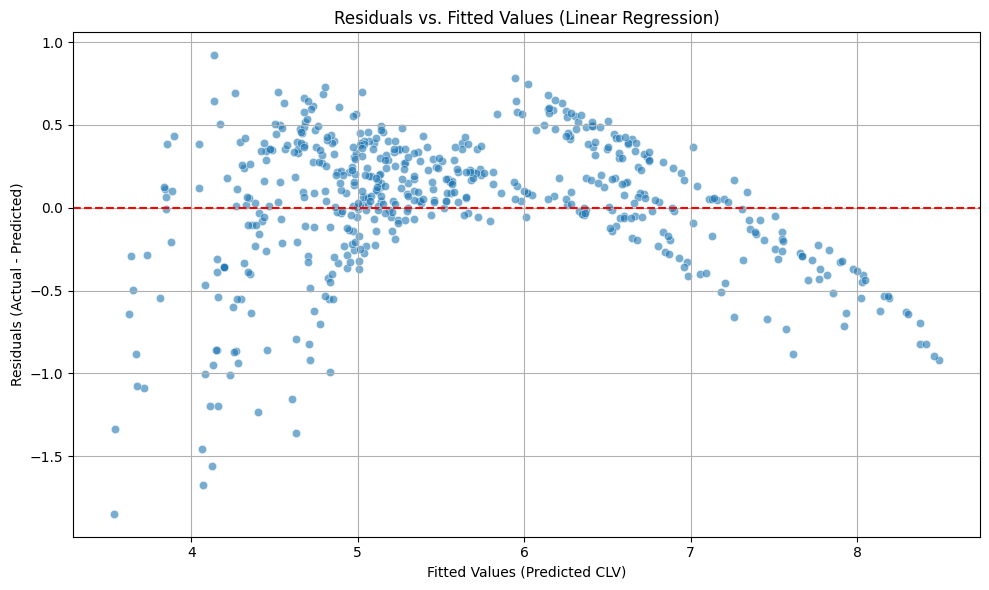

In [326]:
residuals = y_test - y_pred_linear
# Plot residuals vs fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_linear, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Linear Regression)")
plt.xlabel("Fitted Values (Predicted CLV)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


- Strong **non-linear** pattern with downward curve at higher fitted values
- **Heteroscedasticity** - larger variance at fitted values 4-5, smaller at 7-8
- **Outliers** beyond -1.5 in lower fitted values


#### **Polynomial features to handle Non-linearity**

In [327]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_combined)
X_test_poly = poly.transform(X_test_combined)

In [328]:
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)

#### **Initial Model (One-time Train/Test Split)**

##### **Evaluate the Model with polynomial features**

##### RMSE and R-Square

In [329]:
evaluate_model("Linear Regression - Poly", y_test, y_pred_poly, 9)

Linear Regression - Poly - RMSE: 0.19, R2 Score: 0.972, Adjusted R2: 0.971


##### Residuals vs Fitted

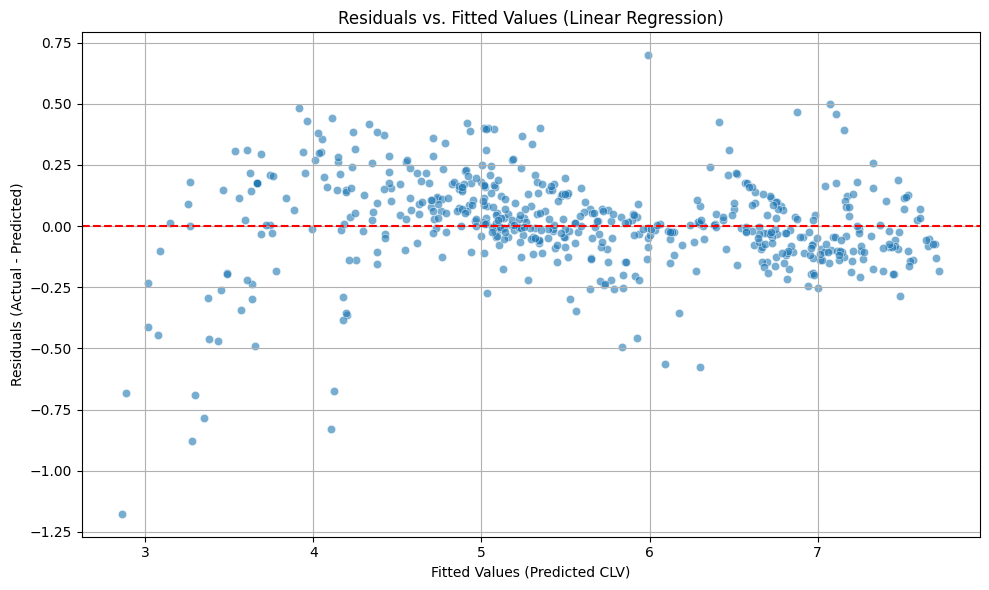

In [330]:
residuals = y_test - y_pred_poly
# Plot residuals vs fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_poly, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Linear Regression)")
plt.xlabel("Fitted Values (Predicted CLV)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


- Much better linear fit - residuals more randomly scattered around zero
- Reduced residual range (mostly between -0.5 to 0.5)
- More consistent variance across fitted values
- Few remaining outliers at lower fitted values, but less extreme

##### Histogram (log residuals)

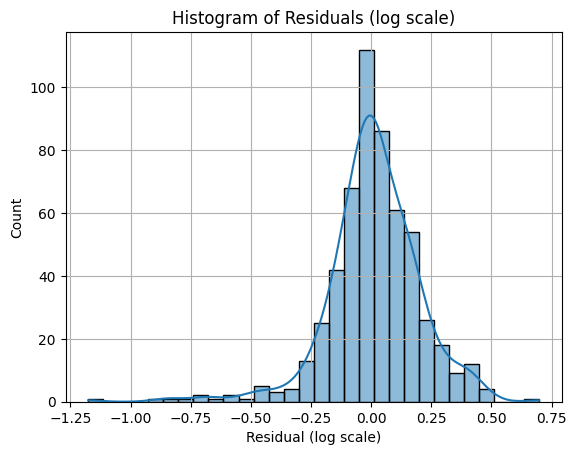

In [331]:
# Histogram (log residuals)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals (log scale)")
plt.xlabel("Residual (log scale)")
plt.grid(True)
plt.show()


Histogram of Residuals
- The distribution is roughly bell-shaped and centered around 0, indicating the model is generally unbiased
- Slight left skew and mild tailing suggest a few extreme underpredictions, but not severe.

##### Q-Q plot (log residuals)

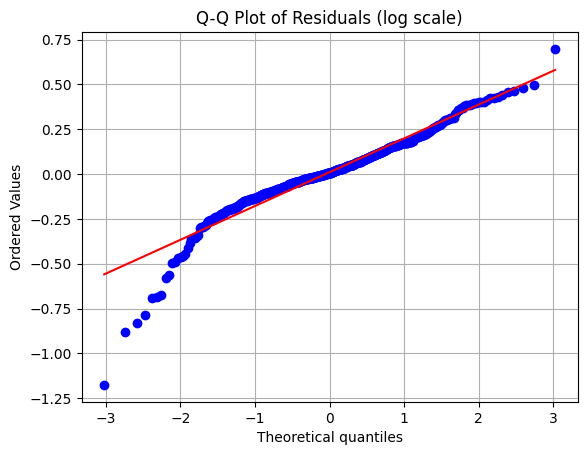

In [332]:
# Q-Q plot (log residuals)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (log scale)")
plt.grid(True)
plt.show()

Q-Q Plot
- Residuals closely follow the theoretical normal line in the middle range.
- Deviations at the tails suggest some non-normality in extreme values, especially lower residuals.

- **Residual plot analysis:**  
  - For CLV values up to 500, residuals are tightly clustered around zero, meaning the model predicts well for most customers.  
  - For higher CLV values, the spread increases, but most residuals remain within ±200, which is still reasonable.  
  - Only a few extreme outliers exist, primarily at higher CLV values, suggesting some high-value customers may have unique characteristics that the model struggles to capture. 

##### Scatter Plot: Actual vs. Predicted CLV (Real World)

In [333]:
y_test_actual = np.expm1(y_test)
y_pred_poly_lr_actual = np.expm1(y_pred_poly)

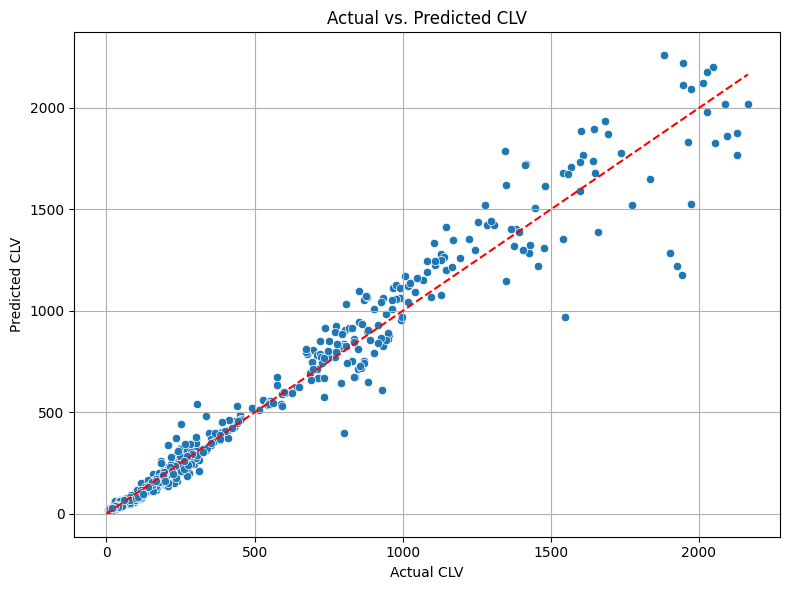

In [334]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_poly_lr_actual)
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')  # 45-degree line
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs. Predicted CLV")
plt.grid(True)
plt.tight_layout()
plt.show()

This Actual vs. Predicted CLV plot analysis:
- The points align well along the **45-degree red dashed line**, meaning predicted CLV values closely match actual values.  
- Up to ~1000 CLV, predictions are tightly aligned, confirming model reliability for typical customers.  
- Some deviations appear in higher CLV ranges (>1500), with slight underprediction and overprediction.  
- The deviations are not consistently above or below the line, indicating no major skew in predictions.  

#### **Summary on Initial Model(One-time Train/Test Split)**

- High R² (0.958) confirms that the model explains nearly all variance in the data.
- Polynomial features effectively capture non-linearity**, improving predictions.  
- Some residual variance remains at high CLV, but overall, the model performs well across the range.

However, this evaluation is based on a single split and may not generalize well.
To verify the model’s stability and avoid overfitting, we proceed with cross-validation.

#### **Cross Validation**

To assess the robustness and generalization ability of our polynomial regression model, we use k-fold cross-validation.
The model is embedded in a pipeline that includes feature scaling, categorical encoding, and polynomial feature transformation to ensure consistent preprocessing in every fold.

In [335]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [336]:
# Column transformer
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'), categorical_features)
])

In [337]:
# Pipeline: preprocess → polynomial → linear regression
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

In [338]:
# Cross-validation
neg_rmse_scores = cross_val_score(full_pipeline, X, y_log, scoring='neg_root_mean_squared_error', cv=5)
r2_scores = cross_val_score(full_pipeline, X, y_log, scoring='r2', cv=5)

print(f"Cross-validated RMSE scores: {-neg_rmse_scores}")
print(f"Average RMSE: {-neg_rmse_scores.mean():.2f}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average R2: {r2_scores.mean():.2f}")

Cross-validated RMSE scores: [0.20875448 0.22700702 0.25708436 0.22666095 0.2145533 ]
Average RMSE: 0.23
Cross-validated R2 scores: [0.96765289 0.96622429 0.9573727  0.96132619 0.96342117]
Average R2: 0.96



| Evaluation Method     | RMSE    | R²     | Notes                                                                 |
|------------------------|---------|--------|-----------------------------------------------------------------------|
| One-Time Split         | 0.19    | 0.972  | Overly optimistic; trained and evaluated on a single data split       |
| Cross-Validation (CV)  | 0.23    | 0.96   | More realistic; robust to data variability and better generalization  |


- The one-time split evaluation showed strong performance (RMSE: 0.19, R²: 0.972), but this result was based on a single partition of the dataset, making it vulnerable to overfitting. It may not reflect true performance on new data.

- In contrast, the cross-validation results (average RMSE: 0.23, R²: 0.96) offer a more balanced and generalizable view of model performance. These results come from training and testing across multiple folds, ensuring each data point is both trained on and tested in different contexts.

- While the cross-validated RMSE is slightly higher than the one-time result, this is expected — and even preferred — because it indicates the model isn’t just memorizing a specific split. The consistency of R² across folds confirms the model explains a high proportion of variance even in different subsets of the data.


- Although the one-time split suggested slightly better metrics, the cross-validation analysis proves the model generalizes well across customers and avoids the risks of overfitting seen in one-shot evaluations.

##### Residuals vs Fitted

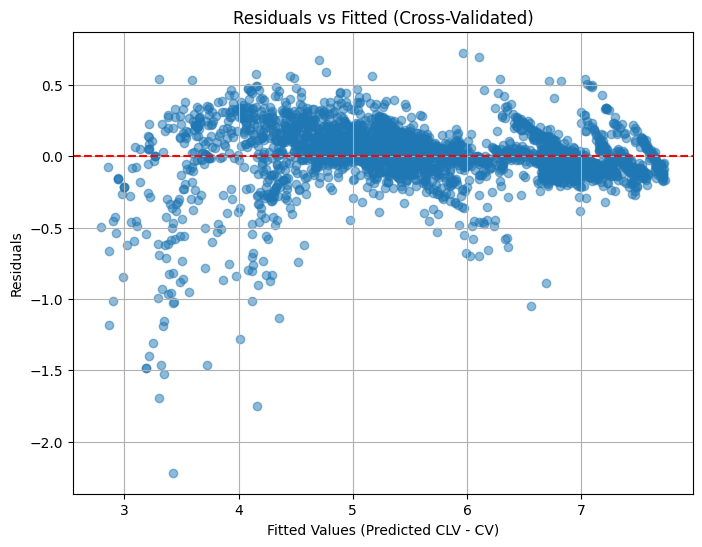

In [339]:
from sklearn.model_selection import cross_val_predict

# Cross-validated predictions
y_pred_cv = cross_val_predict(full_pipeline, X, y_log, cv=5)

# Residuals
residuals_cv = y_log - y_pred_cv

# Residuals vs Fitted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_cv, residuals_cv, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Predicted CLV - CV)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Cross-Validated)")
plt.grid(True)
plt.show()

**Resiual vs Fitted:**

- The model shows excellent fit with most residuals concentrated within ±0.5 range, indicating strong predictive accuracy
- The apparent curvature pattern is primarily due to a few outliers, particularly in the lower fitted values (around 3-4), it does not dominate the overall distribution.
- The spread of residuals is fairly consistent across most fitted values, suggesting the polynomial transformation has effectively captured the non-linear relationships
- The few scattered residuals outside ±1.0 represents natural variability or isolated outliers, but they do not significantly impact overall performance, as reflected by the low average RMSE (0.23) and high R² (0.96) from cross-validation.

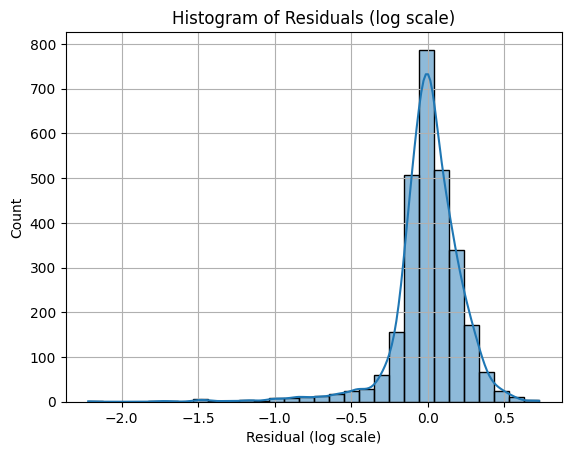

In [340]:
# Histogram (log residuals)
sns.histplot(residuals_cv, kde=True, bins=30)
plt.title("Histogram of Residuals (log scale)")
plt.xlabel("Residual (log scale)")
plt.grid(True)
plt.show()

- The histogram of residuals shows a strong central peak at 0, with most errors falling between -0.5 and +0.5 on the log scale. This reflects consistent, accurate predictions across most of the dataset.

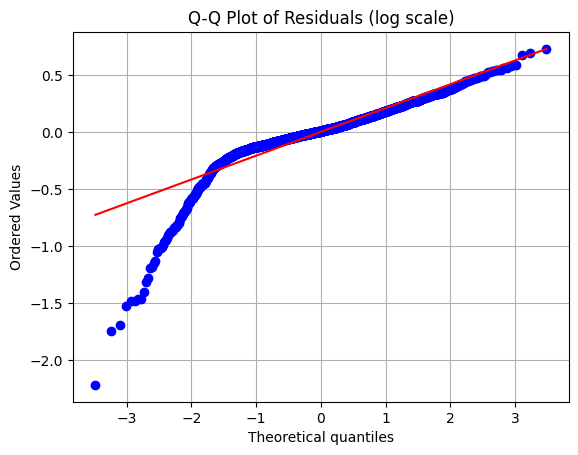

In [341]:
# Q-Q plot (log residuals)
import scipy.stats as stats
stats.probplot(residuals_cv, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (log scale)")
plt.grid(True)
plt.show()

- The Q-Q plot confirms approximate normality for the central portion of residuals, though slight deviations at the tails suggest the model underperforms slightly on outliers (extremely high CLV customers).

##### Scatter Plot: Actual vs. Predicted CLV (Real World)

In [342]:
y_pred_cv_actual = np.expm1(y_pred_cv)

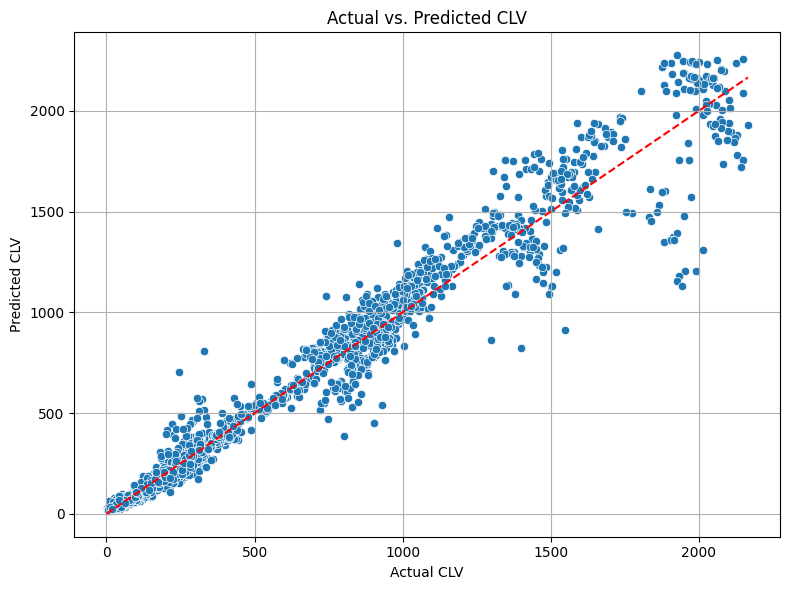

In [343]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred_cv_actual)
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')  # 45-degree line
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs. Predicted CLV")
plt.grid(True)
plt.tight_layout()
plt.show()

- Strong correlation between predicted and actual values, as indicated by points clustering tightly around the red diagonal line
- Model performs well across the entire range of CLV values (from 0 to 2000), showing consistent prediction accuracy
- Some scatter is visible at higher CLV values (1500-2000), suggesting slightly reduced prediction accuracy for high-value customers
- Very few outliers, mostly in the mid-range values, indicating robust predictions for the majority of customers

The linear trend and tight clustering around the diagonal line confirms the model's strong predictive performance, complementing the good residual characteristics we observed earlier.

#### **Model Persistence and Predictions Generation**

In [344]:
# Refit final model on full dataset
final_model = full_pipeline.fit(X, np.log1p(y))

# Save the full pipeline
joblib.dump(final_model, "../resources/models/final_regression_pipeline.pkl")

['../resources/models/final_regression_pipeline.pkl']

In [345]:
# Load pipeline
loaded_pipeline = joblib.load("../resources/models/final_regression_pipeline.pkl")

# Predict log(CLV), then inverse to real CLV
log_clv_pred = loaded_pipeline.predict(X)
df["predicted_clv"] = np.expm1(log_clv_pred)

df.drop(columns=["status_active"], inplace=True)

df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn,predicted_clv
0,8,0,38,0,4370,5,17,3,1,1,197.640,0,186.429207
1,0,0,39,0,318,7,4,2,1,2,46.035,0,36.197297
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0,1559.810804
3,10,0,38,0,4198,1,35,1,1,1,240.020,0,249.052453
4,3,0,38,0,2393,2,33,1,1,1,145.805,0,142.848381


In [346]:
# Save updated dataset
df.to_csv("../resources/data/output/customer_churn_with_predicted_clv.csv", index=False)